In [1]:
# LB of xx
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, list_pictures
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , LearningRateScheduler
from keras.utils.vis_utils import plot_model
from keras.models import load_model 
from keras.layers import Concatenate,Input,ZeroPadding2D,Dense,Flatten,GlobalAveragePooling2D,AveragePooling2D, SpatialDropout2D,Multiply,Conv2D,UpSampling2D, Conv2DTranspose, MaxPooling2D, concatenate,Reshape,RepeatVector, Dropout, BatchNormalization,Add
from keras.layers.core import Activation
from keras import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras import layers
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
from skimage.transform import resize

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.backend import tf as ktf
from keras.regularizers import l2

from clr_callback import *
from lr_new import LRFinder

import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

/home/sourav/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]
train_df["images"] = [np.array(load_img("images/{}.png".format(idx),grayscale = True)) / 255 for idx in train_df.index]
train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx),grayscale = True)) / 255 for idx in train_df.index]

In [3]:
# - Remove images with 1px
train_df = train_df[train_df.masks.map(np.sum) != 1]

In [4]:
train_df["masks_flag"] = (train_df.masks.map(np.sum) > 0)*1

In [5]:
# identifying empty images
x_train_nn = train_df[["images","masks_flag","masks"]].copy()
x_train_nn = x_train_nn[x_train_nn.masks_flag.values>0]

In [6]:
def nn_interpolate(A, new_size):
    """Vectorized Nearest Neighbor Interpolation"""

    old_size = A.shape
    row_ratio, col_ratio = np.array(new_size)/np.array(old_size)

    # row wise interpolation 
    row_idx = (np.ceil(range(1, 1 + int(old_size[0]*row_ratio))/row_ratio) - 1).astype(int)

    # column wise interpolation
    col_idx = (np.ceil(range(1, 1 + int(old_size[1]*col_ratio))/col_ratio) - 1).astype(int)

    final_matrix = A[:, row_idx][col_idx, :]

    return final_matrix

In [7]:
# Change image size from X*Y to X*X
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
#x_train_nn ["coverage"] = x_train_nn.masks.map(np.sum) / pow(img_size_ori, 2)
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5)*1
    cover = sum([cover])
    #print(cover)
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall
        

train_df["coverage_class"] = train_df.coverage.map(get_mask_type) # https://www.kaggle.com/shaojiaxin/u-net-resnet-v3-stratifiedkfold
#x_train_nn["coverage_class"] = train_df.coverage.map(get_mask_type) 

In [9]:
ids_train, ids_valid, x_train, x_valid,  y_train, y_valid,X_feat_train, X_feat_valid,y_train_hasmask,y_valid_hasmask = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target,1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.z.values,
    train_df.masks_flag.values,
    test_size=0.1,stratify=train_df.coverage_class, random_state=1234)

In [10]:
from augmentation import iaa, PadFixed, RandomCropFixedSize
from utils import plot_list
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip
    iaa.OneOf([
        iaa.Noop(),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Noop(),
        iaa.Affine(rotate=(-10, 10), translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0)),
        iaa.Noop(),
        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        iaa.Noop(),
        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
    ])
])

seq_det = seq.to_deterministic()

In [ ]:
AUG_NR = 6
aug_imgs_x = []
aug_imgs_y = []
for i in range(len(x_train)-1):
    for _ in range(AUG_NR):
        img_x = seq_det.augment_image(x_train[i])
        img_y = seq_det.augment_image(y_train[i])
        
        aug_imgs_x.append(img_x),aug_imgs_y.append(img_y)

In [ ]:
aug_imgs_x = np.array(aug_imgs_x)
aug_imgs_y = np.array(aug_imgs_y)

In [13]:
x_train = np.append(x_train,aug_imgs_x,axis=0)
y_train = np.append(y_train,aug_imgs_y,axis=0)

In [11]:
# Horizontal flip
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
#x_train_n = np.append(x_train_n,[np.fliplr(x) for x in x_train_n], axis=0)
#y_train_n = np.append(y_train_n,y_train_n , axis=0)
y_train_hasmask = np.append(y_train_hasmask,y_train_hasmask)

In [12]:
y_train_hasmask = np.zeros((len(y_train)))
for i in range(len(y_train)-1):
    y_train_hasmask[i] =  (y_train[i,:,:,0].sum()>0)*1

In [13]:
x_train.shape, y_train.shape,y_train_hasmask.shape

((7180, 128, 128, 1), (7180, 128, 128, 1), (7180,))

In [14]:
from scipy import ndimage
def add_channel(x_block):
    new_x_train = np.zeros((len(x_block), img_size_target, img_size_target, 3))
    for i in range(x_block.shape[0]):
        new_x_train[i,:,:,0] =  x_block[i,: ,:,0]
        h,w,n = x_block[i,: ,:,:].shape
        for row, const in enumerate(np.linspace(0, 1, h)):
            new_x_train[i,row, : ,1] = const
        new_x_train[i,:,:,2] = ndimage.sobel(x_block[i,: ,:,0], axis=-1, output=None, mode='nearest')#new_x_train[i,:,:,0] * new_x_train[i,:,:,1]
        #new_x_train[i,:,:,3] = ndimage.sobel(x_block[i,: ,:,0], axis=-1, output=None, mode='nearest')
    x_block = new_x_train
    del new_x_train
    return x_block

In [15]:
x_train = add_channel(x_train)
x_valid = add_channel(x_valid)
#x_train_n = add_channel(x_train_n)

In [16]:
def my_crossentropy(target, output):
    _epsilon = 10e-8
    pos_weight = 0.75
    neg_weight = 0.25
    output = K.sigmoid(output)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    return - tf.reduce_sum(target * pos_weight *  (1. - output) * tf.log(output) +
                           (1 - target)  *  neg_weight * output * tf.log(1 - output),
                           len(output.get_shape()) - 1)

def my_crossentropy_non_empty(target, output):
    targetf = tf.cast(target, output.dtype)
    targets = tf.reduce_sum(targetf, axis=[1,2,3])
    losses = my_crossentropy(target, output)
    return tf.where(targets > 0,
                    losses,
                    0*losses
                   )


#focal loss
def focal_loss_fixed(y_true, y_pred):
    gamma=2.0
    alpha=0.2
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

#Dice loss calculation
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + 2*dice_loss(y_true, y_pred))

def focal_dice_loss(y_true, y_pred):
    return (focal_loss_fixed(y_true, y_pred) + 2*dice_loss(y_true, y_pred))

In [17]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)



def my_iou_metric_non_zero(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)


def get_iou_vector_non_zero(A, B):
    # Numpy version
    k = 0
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true != 0:
            
            # non empty mask case.  Union is never empty 
            # hence it is safe to divide by its number of pixels
            intersection = np.sum(t * p)
            union = true + pred - intersection
            #print(union)
            iou = intersection / union

            # iou metrric is a stepwise approximation of the real iou over 0.5
            iou = np.floor(max(0, (iou - 0.45)*20)) / 10

            metric += iou
            k += 1
            
            print("iou",iou,"k",k)
            
    # teake the average over all images in batch
    metric /= k
    return metric



def mean_iou(y_true, y_pred):
    #print(y_true,y_pred)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [18]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [19]:
# Squeeze and excite layer
def sc_se_block(in_block, ch, ratio=16):
    
    # Squeeze block
    x_sq = GlobalAveragePooling2D()(in_block)
    x_sq = Dense(ch//ratio, activation='relu')(x_sq)
    x_sq = Dense(ch, activation='sigmoid')(x_sq)
    
    x_sq = Multiply()([in_block, x_sq])
    
    # Channel Block
    
    x_ch = Conv2D(1, (1, 1), activation="sigmoid")(in_block)
    x_ch = Multiply()([in_block, x_ch])
        
    return Add()([x_sq, x_ch])

In [20]:
def attention_layer(F_int,g,x ,namex):
    g1 = Conv2D(F_int, kernel_size=(3,3),strides=(1,1),padding="same" , name = namex + 'Convgate')(g)
    g1 = BatchNormalization()(g1)
    
    x1 = Conv2D(F_int, kernel_size=(3,3),strides=(1,1),padding="same",name = namex + 'Convresidual')(x)
    x1 = BatchNormalization()(x1)
    
    psi = Add()([g1,x1])
    psi = Activation('relu')(psi)
    psi = Conv2D(1,kernel_size=(3,3),strides=(1,1),padding="same" , name = namex + 'Convadd')(psi)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    
    return Multiply()([x1,psi])

In [21]:
side_block_dict = {}

In [22]:
# Side Layer
def side_branch(x_block, factor):
    
    x_side = Conv2D(1, (1, 1), activation=None, padding='same')(x_block)
    kernel_size = (2*factor, 2*factor)
    x_side_up = Conv2DTranspose(1,kernel_size, strides =(2*factor, 2*factor), padding = 'same' )(x_side)
    #print('side_out_shape',x_side_up.shape)
    
    return x_side_up

In [23]:
def handle_stage_names(stage):
    #print(stage)
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def ConvRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name)(x)
        x = Activation('relu', name=relu_name)(x)
        return x
    return layer


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):

    def layer(input_tensor):
        #print(stage)
        conv_name, bn_name, relu_name, up_name = handle_stage_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            att = attention_layer(filters,x,skip , up_name+'_att')
            x = concatenate([x, att])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_stage_names(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = concatenate([x, skip])

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer

In [24]:
def get_layer_number(model, layer_name):
    """
    Help find layer in Keras model by name
    Args:
        model: Keras `Model`
        layer_name: str, name of layer
    Returns:
        index of layer
    Raises:
        ValueError: if model does not contains layer with such name
    """
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))

def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)
    
def get_model_output(model,layer_name):
    for i,l in enumerate(model.layers):
        print("All labels:" , l.name)
        if l.name == layer_name:
            #print(layer_name)
            #output_val = l.output
            return output_val

In [25]:
def build_unet(backbone, classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               block_type='upsampling',
               activation='sigmoid',
               use_batchnorm=True):

    input_x = backbone.input
    x = backbone.output
    
    hyper_col_name = {}
    
    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])

    for i in range(n_upsample_blocks):
        
        # check if there is a skip connection
        skip_connection = None
        if i < len(skip_connection_idx):
            skip_connection = backbone.layers[skip_connection_idx[i]].output

        upsample_rate = to_tuple(upsample_rates[i])

        x = Upsample2D_block(decoder_filters[i], i, upsample_rate=upsample_rate,
                     skip=skip_connection, use_batchnorm=use_batchnorm)(x)
        
        hyper_col_name [i] = Conv2D(64,1,padding='same',activation=None)(x) 
        
    x = SpatialDropout2D(0.25)(x)
    
    
    ##------------Start of Hyper column --------------------------------------------------------
    '''
    hypercol3 = Concatenate(name='hypercol3')([x,   UpSampling2D(size=(2,   2))(hyper_col_name.get(3))])    
    hypercol2 = Concatenate(name='hypercol2')([hypercol3, UpSampling2D(size=(4,   4))(hyper_col_name.get(2))]) 
    hypercol1 = Concatenate(name='hypercol1')([hypercol2, UpSampling2D(size=(8,   8))(hyper_col_name.get(1))])
    hypercol0 = Concatenate(name='hypercol0')([hypercol1, UpSampling2D(size=(16, 16))(hyper_col_name.get(0))])

    hypercol = Conv2D(64,  (3, 3), activation=None, padding="same")(hypercol0)
    #hypercol0 = Dropout(0.5)(hypercol)
    
    ##------------End of Hyper column --------------------------------------------------------
    '''
    hypercol4 = UpSampling2D(size=(1,   1))(x)
    hypercol3 = UpSampling2D(size=(2,   2))(hyper_col_name.get(3))
    hypercol2 = UpSampling2D(size=(4,   4))(hyper_col_name.get(2)) 
    hypercol1 = UpSampling2D(size=(8,   8))(hyper_col_name.get(1))
    hypercol0 = UpSampling2D(size=(16, 16))(hyper_col_name.get(0)) 
    
    hypercol = concatenate([hypercol0,hypercol1,hypercol2,hypercol3,hypercol4],axis=-1)
    
    hypercol = concatenate([hypercol0,hypercol1,hypercol2,hypercol3,hypercol4])
    x = Conv2D(1, (3,3), padding='same', name='decode_final_conv')(hypercol)    
    out_hyper_colx = Activation('sigmoid', name='final_decode_fuse')(x) #-From decoder
    
    side_fuse_layer1 = side_block_dict.get(0)
    side_fuse_layer1 = GlobalAveragePooling2D(name='global_avg_pooling_1')(side_fuse_layer1)
    side_fuse_layer1 = Dense(1 ,name='side_fuse_layer_1_dense')(side_fuse_layer1)
    side_fuse_layer1 = Activation('sigmoid', name='side_fuse_layer1')(side_fuse_layer1)
    
    side_fuse_layer2 = Concatenate(name='side_fuse_layer2_start')([side_block_dict.get(0), side_block_dict.get(1)])
    side_fuse_layer2 = GlobalAveragePooling2D(name='global_avg_pooling_2')(side_fuse_layer2)
    side_fuse_layer2 = Concatenate(name='side_fuse_layer2_layer1')([side_fuse_layer1,side_fuse_layer2])
    side_fuse_layer2 = Dense(1 ,name='side_fuse_layer_2_dense')(side_fuse_layer2)
    side_fuse_layer2 = Activation('sigmoid', name='side_fuse_layer2')(side_fuse_layer2)
    
    side_fuse_layer3 = Concatenate(name='side_fuse_layer3_start')([side_block_dict.get(0), side_block_dict.get(1), side_block_dict.get(2)])
    side_fuse_layer3 = GlobalAveragePooling2D(name='global_avg_pooling_3')(side_fuse_layer3)
    side_fuse_layer3 = Concatenate(name='side_fuse_layer3_layer2_layer1')([side_fuse_layer1,side_fuse_layer2,side_fuse_layer3])
    side_fuse_layer3 = Dense(1 ,name='side_fuse_layer_3_dense')(side_fuse_layer3)
    side_fuse_layer3 = Activation('sigmoid', name='side_fuse_layer3')(side_fuse_layer3)
    
    side_fuse_layer4_int = Concatenate(name='side_fuse_layer4_int')([side_block_dict.get(0), side_block_dict.get(1), side_block_dict.get(2), side_block_dict.get(3)])
    side_fuse_layer4 = GlobalAveragePooling2D(name='global_avg_pooling_4')(side_fuse_layer4_int)
    side_fuse_layer4 = Concatenate(name='side_fuse_layer4_layer3_layer2_layer1')([side_fuse_layer1,side_fuse_layer2,side_fuse_layer3,side_fuse_layer4])
    side_fuse_layer4 = Dense(1 ,name='side_fuse_layer_4_dense')(side_fuse_layer4)
    side_fuse_layer4 = Activation('sigmoid', name='side_fuse_layer4')(side_fuse_layer4)
    #side_fuse_layer = concatenate([side_block_dict.get(0), side_block_dict.get(1), side_block_dict.get(2), side_block_dict.get(3)])
    #side_fuse_layer = side_block_dict.get(0)
    
    side_fuse_layer_int = Conv2D(64, (1,1), padding='same' ,activation=None)(side_fuse_layer4_int)

    
    fuse_overall_seg = concatenate([out_hyper_colx,side_fuse_layer_int]) # - Decoder + Encoder
    fuse_overall_seg = Conv2D(1, (3,3), padding='same')(fuse_overall_seg)
    fuse_overall_seg = Activation('sigmoid', name='Overall_fuse_conv')(fuse_overall_seg)
    
    model = Model(input_x, output = [side_fuse_layer4,out_hyper_colx,fuse_overall_seg])
    return model

In [26]:
from keras.utils import get_file

weights_collection = [
 {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
 }

]

#weights_collections = load_model('resnet34_imagenet_1000_no_top.h5')


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))


In [27]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)
        
        x = sc_se_block(x, filters*4 , ratio=16)
        
        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

In [28]:
from keras.applications.imagenet_utils import _obtain_input_shape
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):
    
    """
    TODO
    """
    
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=128,
                                      min_size=128,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
   
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x) 
    
    k=1
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
        
        k *=2
        
        side_block_dict[stage]= side_branch(x, k)
        
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)
    
    #side_block_dict[0] = side_branch(x,16)
    
    #side_block = Dense(1, name='fc1')(x)
    #side_block = Activation('sigmoid', name='softmax')(x)
    
    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    
       
    # Create model.
    model = Model(inputs, x)
    #model = Model(inputs=input_layer, outputs=output_layer)
    
    
    return model

def ResNet34(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model

In [29]:
backbones = {
    "resnet34": ResNet34,
}
def get_backbone(name, *args, **kwargs):
    return backbones[name](*args, **kwargs)

In [30]:
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

In [32]:
DEFAULT_SKIP_CONNECTIONS = {
    'resnet34': ('stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0'),
}

def Unet(backbone_name='resnet34',
         input_shape=(None, None, 4),
         input_tensor=None,
         encoder_weights='imagenet',
         freeze_encoder=False,
         skip_connections='default',
         decoder_block_type='upsampling',
         decoder_filters=(256,128,64,32,16),
         decoder_use_batchnorm=True,
         n_upsample_blocks=5,
         upsample_rates=(2,2,2,2,2),
         classes=1,
         activation='sigmoid'):
    """
    Args:
        backbone_name: (str) look at list of available backbones.
        input_shape:  (tuple) dimensions of input data (H, W, C)
        input_tensor: keras tensor
        encoder_weights: one of `None` (random initialization), 'imagenet' (pre-training on ImageNet)
        freeze_encoder: (bool) Set encoder layers weights as non-trainable. Useful for fine-tuning
        skip_connections: if 'default' is used take default skip connections,
            else provide a list of layer numbers or names starting from top of model
        decoder_block_type: (str) one of 'upsampling' and 'transpose' (look at blocks.py)
        decoder_filters: (int) number of convolution filters in last upsample block
        decoder_use_batchnorm: (bool) if True add batch normalisation layer between `Conv2D` ad `Activation` layers
        n_upsample_blocks: (int) a number of upsampling blocks
        upsample_rates: (tuple of int) upsampling rates decoder blocks
        classes: (int) a number of classes for output
        activation: (str) one of keras activations
    Returns:
        keras.models.Model instance
    """



    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=input_tensor,
                            weights=encoder_weights,
                            include_top=False)

    if skip_connections == 'default':
        skip_connections = DEFAULT_SKIP_CONNECTIONS[backbone_name]

    model = build_unet(backbone,
                       classes,
                       skip_connections,
                       decoder_filters=decoder_filters,
                       block_type=decoder_block_type,
                       activation=activation,
                       n_upsample_blocks=n_upsample_blocks,
                       upsample_rates=upsample_rates,
                       use_batchnorm=decoder_use_batchnorm)

    # lock encoder weights for fine-tuning
    if freeze_encoder:
        freeze_model(backbone)
    
    #output = [side_fuse_layer1,side_fuse_layer2,side_fuse_layer3,side_fuse_layer4,side_fuse_layer,
    #                               hypercol3,hyercol2,hypercol1,hypercol0,out_hyper_colx,
    #                               fuse_overall_seg])
    
    model.name = 'u-{}'.format(backbone_name)
    model.compile(optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                  loss = {
                          'side_fuse_layer4': 'binary_crossentropy',
                          'final_decode_fuse':my_crossentropy_non_empty,                        
                        'Overall_fuse_conv': dice_loss
                        },
                  loss_weights ={
                          'side_fuse_layer4':  0.05,
                          'final_decode_fuse': 0.1,                        
                        'Overall_fuse_conv': 1
                        },
                  metrics = {
                          'side_fuse_layer4':  'accuracy',
                          'final_decode_fuse': my_iou_metric_non_zero,                        
                        'Overall_fuse_conv': my_iou_metric                      
                        })
    return model

In [37]:
# Setting up for training
chnl=3
n_features = 1
model = Unet(input_shape=(img_size_target, img_size_target, 3))
early_stopping = EarlyStopping(monitor='final_decode_fuse_my_iou_metric_non_zero',mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", monitor='final_decode_fuse_my_iou_metric_non_zero',mode = 'max',  save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='final_decode_fuse_my_iou_metric_non_zero',mode = 'max',factor=0.1, patience=5, min_lr=0.00000001, verbose=1)
#lr = 0.0005
#clr_triangular = CyclicLR(mode='exp_range', gamma=0.99994)
#clr_triangular._reset(new_base_lr=lr, new_max_lr= lr * 3)

/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("da..., outputs=[<tf.Tenso...)`


In [38]:
epochs = 100
batch_size = 64

#lr_finder = LRFinder(min_lr=1e-5,max_lr=1e-2, steps_per_epoch=35, epochs=3)
#model.compile(optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08))
pred_out = model.fit(x_train, [y_train_hasmask,y_train,y_train],
                    validation_data=(x_valid, [y_valid_hasmask,y_valid,y_valid]), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],shuffle=True)


Train on 7180 samples, validate on 399 samples
Epoch 1/100
7180/7180 [==============================] - 47s 7ms/step - loss: 0.3970 - side_fuse_layer4_loss: 0.8761 - final_decode_fuse_loss: 0.0640 - Overall_fuse_conv_loss: 0.3468 - side_fuse_layer4_acc: 0.4563 - final_decode_fuse_my_iou_metric_non_zero: 0.4698 - Overall_fuse_conv_my_iou_metric: 0.3221 - val_loss: 0.2660 - val_side_fuse_layer4_loss: 0.5201 - val_final_decode_fuse_loss: 0.0602 - val_Overall_fuse_conv_loss: 0.2340 - val_side_fuse_layer4_acc: 0.6917 - val_final_decode_fuse_my_iou_metric_non_zero: 0.5128 - val_Overall_fuse_conv_my_iou_metric: 0.4937

Epoch 00001: final_decode_fuse_my_iou_metric_non_zero improved from -inf to 0.46982, saving model to ./keras.model
Epoch 2/100
7180/7180 [==============================] - 39s 5ms/step - loss: 0.2342 - side_fuse_layer4_loss: 0.4675 - final_decode_fuse_loss: 0.0607 - Overall_fuse_conv_loss: 0.2047 - side_fuse_layer4_acc: 0.7763 - final_decode_fuse_my_iou_metric_non_zero: 0.5343 

KeyboardInterrupt: 

In [35]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])

    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [54]:
model.load_weights("./keras.model")

In [90]:
schedule = SGDRScheduler(min_lr=1e-7,
                                     max_lr=1e-4,
                                     steps_per_epoch=3,
                                     lr_decay=0.5,
                                     cycle_length=5,
                                     mult_factor=1.5)

In [91]:
epochs = 30

pred_out2 = model.fit(x_train, [y_train_hasmask,y_train,y_train],
                    validation_data=(x_valid, [y_valid_hasmask,y_valid,y_valid]), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, schedule],shuffle=True)


ValueError: Error when checking input: expected data to have shape (128, 128, 3) but got array with shape (128, 128, 4)

In [64]:
epochs = 5
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", monitor='val_final_decode_fuse_my_iou_metric',mode = 'max',  save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00000001, verbose=1)
pred_out2 = model.fit(x_train, [y_train_hasmask,y_train,y_train],
                    validation_data=(x_valid, [y_valid_hasmask,y_valid,y_valid]), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, schedule],shuffle=True)


Train on 25124 samples, validate on 399 samples
Epoch 1/5
25124/25124 [==============================] - 155s 6ms/step - loss: 0.0239 - side_fuse_layer4_loss: 0.0036 - final_decode_fuse_loss: 0.0110 - Overall_fuse_conv_loss: 0.0226 - side_fuse_layer4_acc: 0.9998 - final_decode_fuse_my_iou_metric: 0.9344 - Overall_fuse_conv_my_iou_metric: 0.8840 - val_loss: 0.1175 - val_side_fuse_layer4_loss: 0.3895 - val_final_decode_fuse_loss: 0.0843 - val_Overall_fuse_conv_loss: 0.0896 - val_side_fuse_layer4_acc: 0.9298 - val_final_decode_fuse_my_iou_metric: 0.8095 - val_Overall_fuse_conv_my_iou_metric: 0.7957

Epoch 00001: val_final_decode_fuse_my_iou_metric improved from -inf to 0.80952, saving model to ./keras.model
Epoch 2/5
25124/25124 [==============================] - 148s 6ms/step - loss: 0.0235 - side_fuse_layer4_loss: 0.0043 - final_decode_fuse_loss: 0.0108 - Overall_fuse_conv_loss: 0.0222 - side_fuse_layer4_acc: 0.9997 - final_decode_fuse_my_iou_metric: 0.9348 - Overall_fuse_conv_my_iou_me

In [ ]:
model.load_weights("./keras.model")

In [65]:
#preds_test1,preds_test2,preds_test3 = model.predict(x_valid)

In [66]:
preds_test1_new = ((preds_test1>0.5)*1)

In [121]:
y_valid_flag = []
ids_valid_flag = []
for i in range(len(y_valid)):
    y_valid_flag.append((y_valid[i,:,:,0].sum()>0)*1)
    if y_valid_flag[i]>0:
        ids_valid_flag.append(ids_valid[i])

In [75]:
import sklearn
cf = sklearn.metrics.confusion_matrix(y_valid_flag, preds_test1_new, labels=None, sample_weight=None)

In [122]:
cf,x_valid_maskonly.shape, len(ids_valid_flag)

(array([[146,  17],
        [ 10, 226]]), (236, 128, 128, 3), 236)

In [98]:
#### Get non_zero images for prediction by pred_test2
x_valid_maskonly =[]
for i in range(len(y_valid_flag)):
    if y_valid_flag[i]>0:
        x_valid_maskonly.append(x_valid[i,:,:,:])

x_valid_maskonly = np.array(x_valid_maskonly)

In [159]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    
    preds_test1 = model.predict(x_test)
    
    '''
    #test time augmentation 
    
    AUG_NR = 6
    aug_imgs_tta = []
    for i in range(len(x_test)-1):
        for _ in range(AUG_NR):
            img_x = seq_det.augment_image(x_test[i])
            aug_imgs_tta.append(img_x)

    aug_imgs_tta = np.array(aug_imgs_tta)
    # x_train = np.append(x_train,aug_imgs_x,axis=0)
    '''
    x_test_flip =  np.array([np.fliplr(x) for x in x_test])
    preds_test2_flip = model.predict(x_test_flip)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_flip[2]] )
     
    preds_avg = (preds_test1[2] +preds_test2[2])/2
    
   # del x_test_flip , preds_test1, preds_test2_flip
    print(len(preds_avg))
    
    return preds_avg

In [215]:
x_valid.shape , x_valid_maskonly.shape

((399, 128, 128, 3), (236, 128, 128, 3))

In [203]:
#preds_valid = predict_result(model,x_valid,img_size_target)#.reshape(-1, img_size_target, img_size_target)
preds_valid = model.predict(x_valid)#.reshape(-1, img_size_target, img_size_target)

classify=[]
classify = (preds_valid[0]>0.5)*1

preds_valid = preds_valid[1]
preds_valid_new = []
for i in range(len(x_valid)):
    preds_valid_new.append(classify[i] * preds_valid[i,:,:,0])

preds_valid = np.array(preds_valid_new).reshape(-1, img_size_target, img_size_target)
#preds_valid_hr = np.array([np.fliplr(x) for x in x_test])
#preds_valid = predictions
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

In [204]:
preds_valid.shape,y_valid_ori.shape

((399, 101, 101), (399, 101, 101))

In [194]:
# Intersection over union
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = get_iou_vector(y_true_in[batch], y_pred_in[batch])
        #print(value)
        metric.append(value)
    return np.mean(metric)

In [205]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in thresholds])

In [206]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

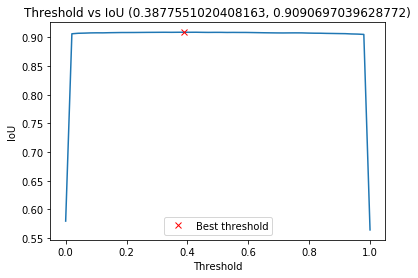

In [207]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [208]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [199]:
test_df["test"] = [np.array(load_img("test/{}.png".format(idx),grayscale = True)) / 255 for idx in test_df.index]

/home/sourav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [227]:
x_test=np.array(test_df.test.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target,1)

In [228]:
new_x_test = np.zeros((len(x_test), img_size_target, img_size_target, 3))
for i in range(x_test.shape[0]):
    new_x_test[i,:,:,0] =  x_test[i,: ,:,0]
    h,w,n = x_test[i,: ,:,:].shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        #print(const)
        new_x_test[i,row, : ,1] = const
    new_x_test[i,:,:,2] = new_x_test[i,:,:,0] * new_x_test[i,:,:,1]
    #img = add_depth_channels(x_train[i,: ,:,:])

x_test = new_x_test
del new_x_test

In [229]:
x_test.shape

(18000, 128, 128, 3)

In [214]:
preds_test = model.predict(x_test)#.reshape(-1, img_size_target, img_size_target)
#preds_test = predict_result(model,x_test,img_size_target)
#classify_test=[]
#classify_test = (preds_test[0]>0.5)*1
#len(classify_test)

preds_test = preds_test[2]
preds_test_new = []
for i in range(len(x_test)):    
    preds_test_new.append(classify_test[i] * preds_test[i,:,:,0])

preds_test = np.array(preds_test_new).reshape(-1, img_size_target, img_size_target)

In [223]:
del preds_valid

In [224]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(test_df.index.values)}

In [225]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission8_b963c_bestthre.csv')

In [226]:
pred_dict=None
pred_test=None